In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
import cv2
from PIL import Image

# --- Paths and Configuration ---
ROOT = r"/home/msi/Documents/IIT-H/src"
GOOD_IMAGES_DIR = os.path.join(ROOT, "training_data", "good_images")
BAD_IMAGES_DIR = os.path.join(ROOT, "training_data", "bad_images")
GOOD_MASKS_DIR = os.path.join(ROOT, "training_data", "good_masks")
BAD_MASKS_DIR = os.path.join(ROOT, "training_data", "bad_masks")
SAVED_CLASSIFIER_PATH = os.path.join(ROOT, "results", "classifier", "se_resnext50_classifier.pth")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = (224, 224)
batch_size = 8
num_epochs = 20
learning_rate = 1e-4

# --- Dataset ---
class ImageMaskDataset(Dataset):
    def __init__(self, image_dir, mask_dir, label, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.label = label
        self.transform = transform
        self.files = [f for f in os.listdir(image_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.files[idx])
        mask_path = os.path.join(self.mask_dir, self.files[idx])
        
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        if self.transform:
            image = Image.fromarray(image).resize(input_size)
            mask = Image.fromarray(mask).resize(input_size)
            image = self.transform(image)
            mask = self.transform(mask)
        
        x = torch.cat([image, mask], dim=0)  # 2-channel input
        y = torch.tensor([self.label], dtype=torch.float32)
        return x, y

# --- Transforms ---
transform = transforms.Compose([transforms.ToTensor()])

# --- Prepare DataLoaders ---
good_dataset = ImageMaskDataset(GOOD_IMAGES_DIR, GOOD_MASKS_DIR, label=1, transform=transform)
bad_dataset = ImageMaskDataset(BAD_IMAGES_DIR, BAD_MASKS_DIR, label=0, transform=transform)
full_dataset = good_dataset + bad_dataset

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# --- Model ---
def get_model():
    try:
        model = models.resnext50_32x4d(weights=models.ResNeXt50_32X4D_Weights.IMAGENET1K_V1)
    except AttributeError:
        model = models.resnext50_32x4d(pretrained=True)

    # Modify first conv for 2-channel input
    orig_conv = model.conv1
    model.conv1 = nn.Conv2d(
        2, orig_conv.out_channels, kernel_size=orig_conv.kernel_size,
        stride=orig_conv.stride, padding=orig_conv.padding, bias=orig_conv.bias
    )
    with torch.no_grad():
        model.conv1.weight[:, 0, :, :] = orig_conv.weight[:, 0, :, :]  # image
        model.conv1.weight[:, 1, :, :] = orig_conv.weight[:, 0, :, :]  # mask

    # Freeze all layers
    for param in model.parameters():
        param.requires_grad = False

    # Unfreeze last two residual layers and final fc
    for param in model.layer3.parameters():
        param.requires_grad = True
    for param in model.layer4.parameters():
        param.requires_grad = True

    # Final classification layer
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, 1)
    for param in model.fc.parameters():
        param.requires_grad = True

    return model.to(device)

model = get_model()
criterion = nn.BCEWithLogitsLoss()

# Only train unfrozen parameters
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)

# --- Training Loop ---
best_val_acc = 0
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for x_batch, y_batch in train_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs.squeeze(), y_batch.squeeze())
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x_batch.size(0)
        preds = (torch.sigmoid(outputs) > 0.5).float()
        correct += (preds.squeeze() == y_batch.squeeze()).sum().item()
        total += x_batch.size(0)
    train_acc = correct / total
    train_loss = total_loss / total

    # Validation
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val, y_val = x_val.to(device), y_val.to(device)
            outputs = model(x_val)
            preds = (torch.sigmoid(outputs) > 0.5).float()
            correct += (preds.squeeze() == y_val.squeeze()).sum().item()
            total += x_val.size(0)
    val_acc = correct / total

    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), SAVED_CLASSIFIER_PATH)
        print("Saved best model!")

print("Training complete. Best validation accuracy:", best_val_acc)



Epoch 1/20 | Train Loss: 0.2816 | Train Acc: 0.8896 | Val Acc: 0.8750
Saved best model!
Epoch 2/20 | Train Loss: 0.1462 | Train Acc: 0.9437 | Val Acc: 0.9500
Saved best model!
Epoch 3/20 | Train Loss: 0.0653 | Train Acc: 0.9833 | Val Acc: 0.9750
Saved best model!
Epoch 4/20 | Train Loss: 0.1513 | Train Acc: 0.9542 | Val Acc: 0.9333
Epoch 5/20 | Train Loss: 0.0822 | Train Acc: 0.9854 | Val Acc: 0.9667
Epoch 6/20 | Train Loss: 0.0781 | Train Acc: 0.9729 | Val Acc: 0.9750
Epoch 7/20 | Train Loss: 0.0294 | Train Acc: 0.9896 | Val Acc: 0.9833
Saved best model!
Epoch 8/20 | Train Loss: 0.0135 | Train Acc: 0.9979 | Val Acc: 0.9750
Epoch 9/20 | Train Loss: 0.0503 | Train Acc: 0.9938 | Val Acc: 0.9833
Epoch 10/20 | Train Loss: 0.0518 | Train Acc: 0.9729 | Val Acc: 0.9833
Epoch 11/20 | Train Loss: 0.0720 | Train Acc: 0.9833 | Val Acc: 0.9667
Epoch 12/20 | Train Loss: 0.0637 | Train Acc: 0.9833 | Val Acc: 0.9750
Epoch 13/20 | Train Loss: 0.0454 | Train Acc: 0.9896 | Val Acc: 0.9750
Epoch 14/20 | 

Loading classifier...


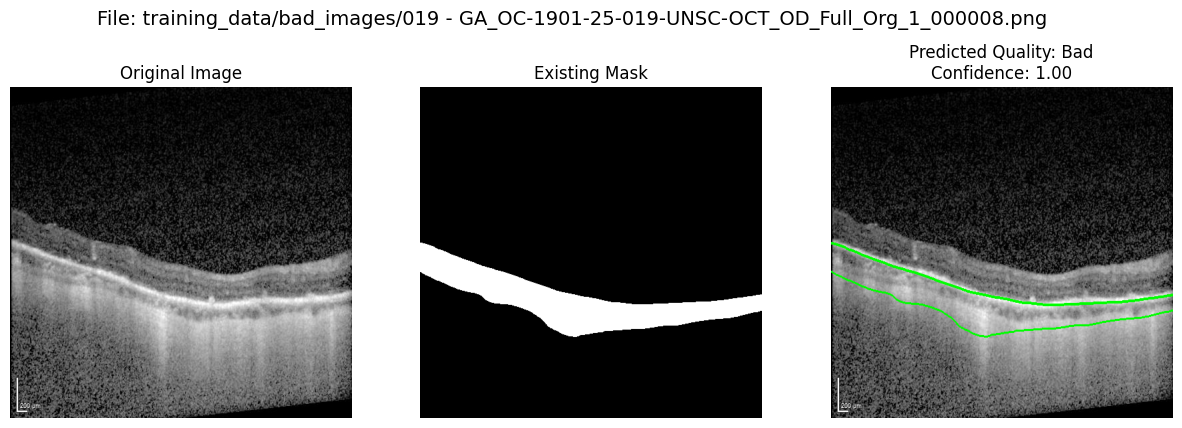

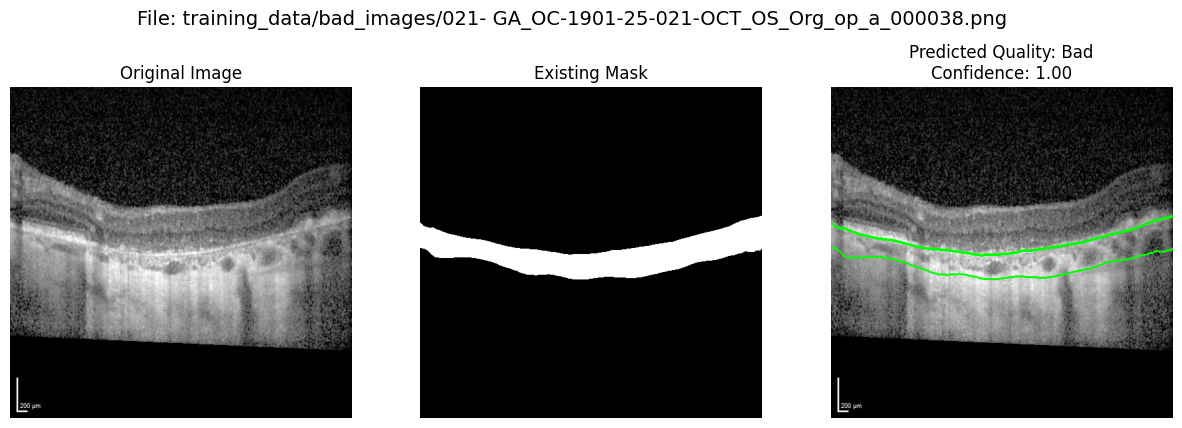

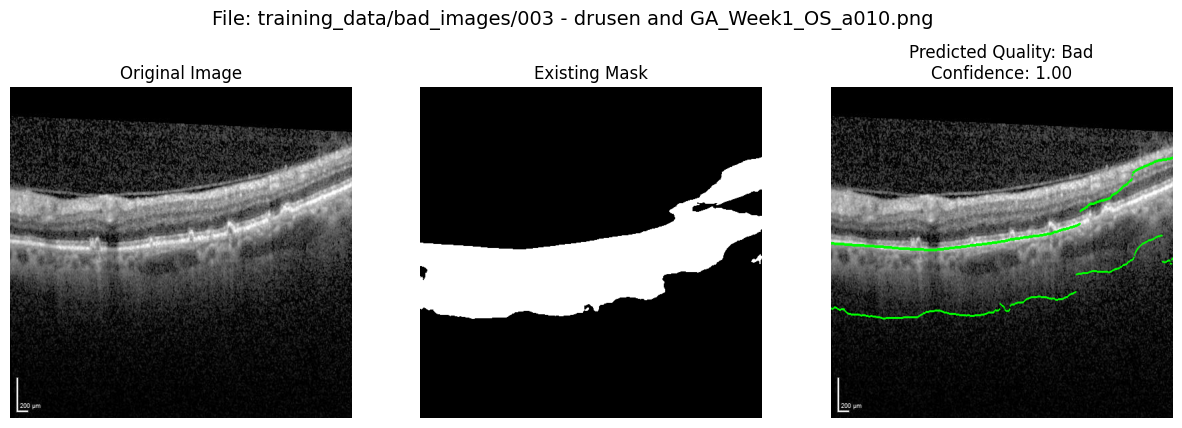

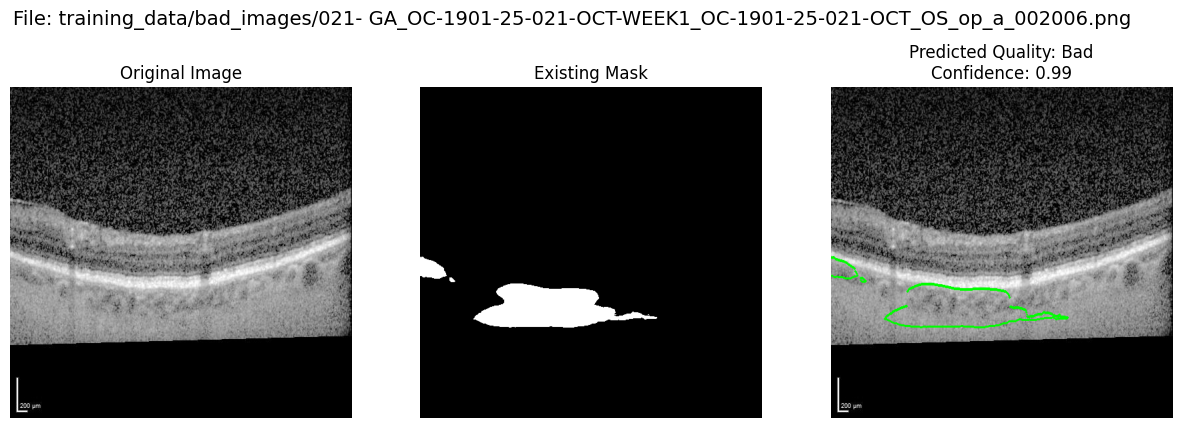

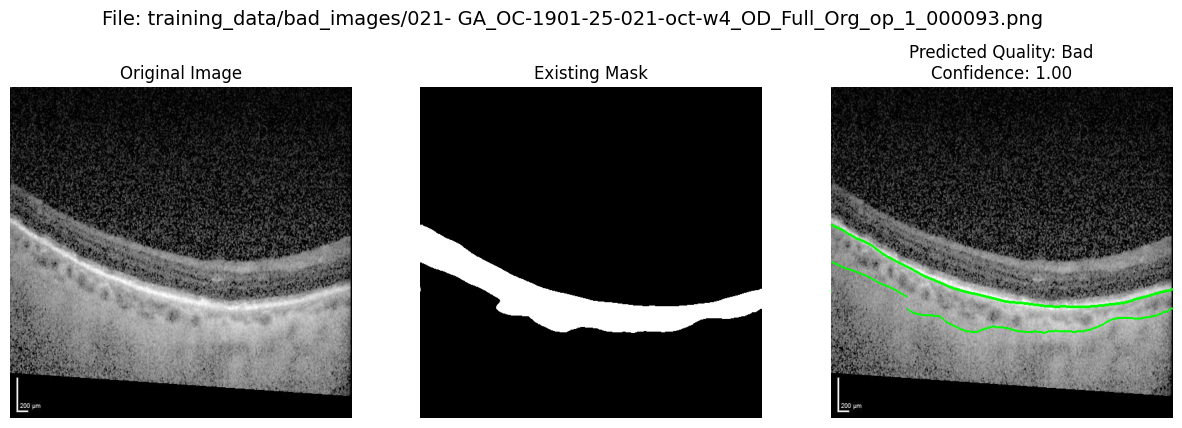

In [1]:
import os
import torch
import torch.nn as nn
from torchvision import transforms, models
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
from PIL import Image

# --- Paths and Configuration ---
ROOT = r"/home/msi/Documents/IIT-H/src"
SAVED_CLASSIFIER_PATH = os.path.join(ROOT, "results", "classifier", "se_resnext50_classifier.pth")
GOOD_IMAGES_DIR = os.path.join(ROOT, "training_data", "good_images")
BAD_IMAGES_DIR = os.path.join(ROOT, "training_data", "bad_images")
GOOD_MASKS_DIR = os.path.join(ROOT, "training_data", "good_masks")
BAD_MASKS_DIR = os.path.join(ROOT, "training_data", "bad_masks")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = (224, 224)

# -------------------------------
# Load SE-ResNeXt50 Classifier (2-channel input)
# -------------------------------
def get_classifier_model(path, device):
    print("Loading classifier...")
    model = models.resnext50_32x4d(weights=models.ResNeXt50_32X4D_Weights.IMAGENET1K_V1)
    
    # Adjust first conv layer for 2-channel input (image + mask)
    orig_conv1 = model.conv1
    new_conv1 = nn.Conv2d(2, orig_conv1.out_channels, 
                          kernel_size=orig_conv1.kernel_size, 
                          stride=orig_conv1.stride, 
                          padding=orig_conv1.padding,
                          bias=orig_conv1.bias)
    with torch.no_grad():
        # replicate the first channel weights for second channel
        new_conv1.weight[:, 0, :, :] = orig_conv1.weight[:, 0, :, :]
        new_conv1.weight[:, 1, :, :] = orig_conv1.weight[:, 0, :, :]
    model.conv1 = new_conv1

    # Final classification layer
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, 1)

    model.load_state_dict(torch.load(path, map_location=device))
    model.to(device).eval()
    return model

# -------------------------------
# Utilities
# -------------------------------
def create_boundaries(mask, first_only=False):
    """Generate per-column boundaries from mask."""
    h, w = mask.shape
    boundary = np.zeros_like(mask)
    for col in range(w):
        indices = np.where(mask[:, col] > 0)[0]
        if indices.size > 0:
            # first pixel
            boundary[indices[0], col] = 255
            # second pixel if exists and not first_only
            if not first_only and indices.size > 1:
                boundary[indices[1], col] = 255
                # last pixel
                boundary[indices[-1], col] = 255
    return boundary

def preprocess_image_and_mask(img_path, mask_path, size):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    img_resized = cv2.resize(img, size)
    mask_resized = cv2.resize(mask, size)
    img_tensor = transforms.ToTensor()(img_resized)
    mask_tensor = transforms.ToTensor()(mask_resized)
    return img_tensor, mask_tensor, img, mask

# -------------------------------
# Main pipeline
# -------------------------------
def run_pipeline(image_paths, mask_dir, classifier_model):
    for img_path in image_paths:
        filename = os.path.basename(img_path)
        mask_path = os.path.join(mask_dir, filename)
        if not os.path.exists(mask_path):
            print(f"Mask not found for {filename}, skipping.")
            continue

        img_tensor, mask_tensor, original_img, original_mask = preprocess_image_and_mask(
            img_path, mask_path, input_size
        )

        # 2-channel input
        input_2ch = torch.cat([img_tensor, mask_tensor], dim=0).unsqueeze(0).to(device)

        # Classifier prediction
        with torch.no_grad():
            out = classifier_model(input_2ch)
            prob = torch.sigmoid(out).item()
            label = "Good" if prob > 0.5 else "Bad"
            confidence = prob if prob > 0.5 else 1 - prob

        # Overlay thicker boundaries
        boundary = create_boundaries(original_mask)
        overlay = cv2.cvtColor(original_img, cv2.COLOR_GRAY2RGB)
        ys, xs = np.where(boundary == 255)
        for y, x in zip(ys, xs):
            cv2.circle(overlay, (x, y), 1, (0, 255, 0), -1)

        # Display results
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
        axes[0].imshow(original_img, cmap='gray')
        axes[0].set_title("Original Image")
        axes[0].axis('off')

        axes[1].imshow(original_mask, cmap='gray')
        axes[1].set_title("Existing Mask")
        axes[1].axis('off')

        axes[2].imshow(overlay)
        axes[2].set_title(f"Predicted Quality: {label}\nConfidence: {confidence:.2f}")
        axes[2].axis('off')

        rel_path = os.path.relpath(img_path, ROOT)
        plt.suptitle(f"File: {rel_path}", fontsize=14)
        plt.show()


# -------------------------------
# Gather all image paths
# -------------------------------
all_image_paths = []
for folder in [GOOD_IMAGES_DIR, BAD_IMAGES_DIR]:
    for f in os.listdir(folder):
        if f.lower().endswith(('.png', '.jpg', '.jpeg')):
            all_image_paths.append(os.path.join(folder, f))

# -------------------------------
# Run
# -------------------------------
classifier_model = get_classifier_model(SAVED_CLASSIFIER_PATH, device)

# Random 5 images for demo
demo_images = random.sample(all_image_paths, min(5, len(all_image_paths)))
for img_path in demo_images:
    mask_dir = GOOD_MASKS_DIR if img_path.startswith(GOOD_IMAGES_DIR) else BAD_MASKS_DIR
    run_pipeline([img_path], mask_dir, classifier_model)


In [1]:
import os
import torch
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
import cv2
from PIL import Image
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
import numpy as np

# --- Paths and Config ---
ROOT = r"/home/msi/Documents/IIT-H/src"
SAVED_CLASSIFIER_PATH = os.path.join(ROOT, "results", "classifier", "se_resnext50_classifier.pth")
GOOD_IMAGES_DIR = os.path.join(ROOT, "training_data", "good_images_all")
BAD_IMAGES_DIR = os.path.join(ROOT, "training_data", "bad_images_all")
GOOD_MASKS_DIR = os.path.join(ROOT, "training_data", "good_masks_all")
BAD_MASKS_DIR = os.path.join(ROOT, "training_data", "bad_masks_all")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = (224, 224)
batch_size = 8

# --- Dataset ---
class ImageMaskDataset(Dataset):
    def __init__(self, image_dir, mask_dir, label, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.label = label
        self.transform = transform
        self.files = [f for f in os.listdir(image_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_filename = self.files[idx]
        img_path = os.path.join(self.image_dir, img_filename)
        base_name = os.path.splitext(img_filename)[0]

        # Attempt to find corresponding mask
        mask_path = os.path.join(self.mask_dir, base_name + ".png")
        if not os.path.exists(mask_path):
            mask_path = os.path.join(self.mask_dir, base_name + ".jpg")
            if not os.path.exists(mask_path):
                raise FileNotFoundError(f"Mask not found for {img_filename}")

        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if image is None or mask is None:
            raise FileNotFoundError(f"Could not read image or mask: {img_path}, {mask_path}")

        if self.transform:
            image = Image.fromarray(image).resize(input_size)
            mask = Image.fromarray(mask).resize(input_size)
            image = self.transform(image)
            mask = self.transform(mask)

        x = torch.cat([image, mask], dim=0)  # 2-channel input
        y = torch.tensor([self.label], dtype=torch.float32)
        return x, y


# --- Transform ---
transform = transforms.Compose([transforms.ToTensor()])

# --- Prepare DataLoader ---
good_dataset = ImageMaskDataset(GOOD_IMAGES_DIR, GOOD_MASKS_DIR, label=1, transform=transform)
bad_dataset = ImageMaskDataset(BAD_IMAGES_DIR, BAD_MASKS_DIR, label=0, transform=transform)
full_dataset = good_dataset + bad_dataset
val_loader = DataLoader(full_dataset, batch_size=batch_size, shuffle=False)

# --- Load Model ---
def get_model():
    model = models.resnext50_32x4d(weights=models.ResNeXt50_32X4D_Weights.IMAGENET1K_V1)
    orig_conv = model.conv1
    model.conv1 = torch.nn.Conv2d(2, orig_conv.out_channels, 
                                  kernel_size=orig_conv.kernel_size,
                                  stride=orig_conv.stride,
                                  padding=orig_conv.padding,
                                  bias=orig_conv.bias)
    with torch.no_grad():
        model.conv1.weight[:, 0, :, :] = orig_conv.weight[:, 0, :, :]
        model.conv1.weight[:, 1, :, :] = orig_conv.weight[:, 0, :, :]

    in_features = model.fc.in_features
    model.fc = torch.nn.Linear(in_features, 1)
    model.load_state_dict(torch.load(SAVED_CLASSIFIER_PATH, map_location=device))
    model.to(device).eval()
    return model

model = get_model()

# --- Evaluation Loop ---
all_preds = []
all_labels = []

with torch.no_grad():
    for x_batch, y_batch in val_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        outputs = model(x_batch)
        probs = torch.sigmoid(outputs).squeeze().cpu().numpy()
        preds = (probs > 0.5).astype(int)

        all_preds.extend(preds)
        all_labels.extend(y_batch.squeeze().cpu().numpy())


all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Compute Metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
conf_matrix = confusion_matrix(all_labels, all_preds)

print(f"Accuracy:         {accuracy:.4f}")
print(f"Precision:        {precision:.4f}")
print(f"Recall:           {recall:.4f}")
print(f"F1 Score:         {f1:.4f}")
print("Confusion Matrix:")
print(conf_matrix)


Accuracy:         0.9670
Precision:        0.8365
Recall:           1.0000
F1 Score:         0.9110
Confusion Matrix:
[[1645   68]
 [   0  348]]


In [3]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix

# Compute metrics for both classes
precision_per_class = precision_score(all_labels, all_preds, average=None)  # [class 0, class 1]
recall_per_class    = recall_score(all_labels, all_preds, average=None)
f1_per_class        = f1_score(all_labels, all_preds, average=None)

# Macro averages
precision_macro = precision_score(all_labels, all_preds, average='macro')
recall_macro    = recall_score(all_labels, all_preds, average='macro')
f1_macro        = f1_score(all_labels, all_preds, average='macro')

# Accuracy (overall)
accuracy = accuracy_score(all_labels, all_preds)
conf_matrix = confusion_matrix(all_labels, all_preds)

print(f"Overall Accuracy: {accuracy:.4f}\n")
print("Per-class Metrics:")
print(f"Class 0 (Good Images) - Precision: {precision_per_class[0]:.4f}, Recall: {recall_per_class[0]:.4f}, F1: {f1_per_class[0]:.4f}")
print(f"Class 1 (Bad Images) - Precision: {precision_per_class[1]:.4f}, Recall: {recall_per_class[1]:.4f}, F1: {f1_per_class[1]:.4f}\n")
print("Macro-Average Metrics:")
print(f"Precision (macro): {precision_macro:.4f}")
print(f"Recall (macro):    {recall_macro:.4f}")
print(f"F1 Score (macro):  {f1_macro:.4f}\n")
print("Confusion Matrix:")
print(conf_matrix)

Overall Accuracy: 0.9670

Per-class Metrics:
Class 0 (Good Images) - Precision: 1.0000, Recall: 0.9603, F1: 0.9797
Class 1 (Bad Images) - Precision: 0.8365, Recall: 1.0000, F1: 0.9110

Macro-Average Metrics:
Precision (macro): 0.9183
Recall (macro):    0.9802
F1 Score (macro):  0.9454

Confusion Matrix:
[[1645   68]
 [   0  348]]


In [4]:
import torch.nn as nn

# --- Hook to capture penultimate features ---
features_list = []

def hook_fn(module, input, output):
    features_list.append(output.detach().cpu())

# Attach hook to the layer just before the final FC
model.fc.register_forward_hook(hook_fn)

# --- Run data through model ---
with torch.no_grad():
    for x_batch, _ in val_loader:
        x_batch = x_batch.to(device)
        _ = model(x_batch)

# Concatenate all features
all_features = torch.cat(features_list, dim=0).numpy()

# --- Split by class for MCD calculation ---
labels = np.array([y.item() for _, y in full_dataset])
class0_features = all_features[labels == 0]
class1_features = all_features[labels == 1]

# Compute Mean Cluster Difference (euclidean distance between class means)
mean0 = class0_features.mean(axis=0)
mean1 = class1_features.mean(axis=0)
mcd = np.linalg.norm(mean0 - mean1)

print(f"Mean Cluster Difference (mask+image model): {mcd:.4f}")


Mean Cluster Difference (mask+image model): 15.1763


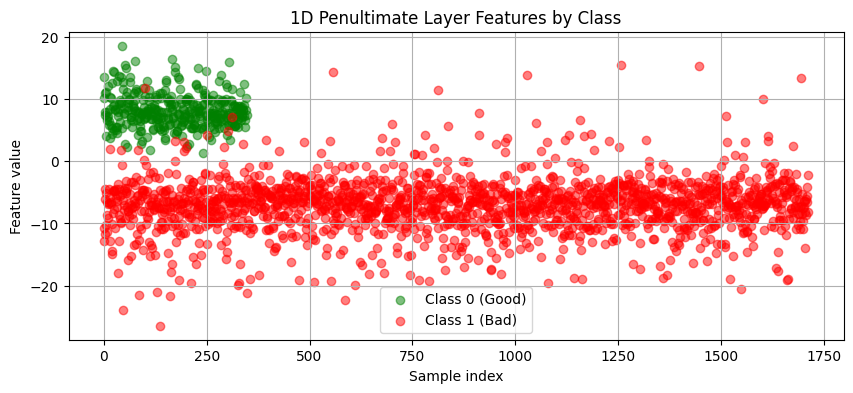

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# all_features: (N,1)
# all_labels: (N,)

# Split by class
class0_features = all_features[all_labels == 1].flatten()
class1_features = all_features[all_labels == 0].flatten()

# Plot
plt.figure(figsize=(10,4))
plt.scatter(np.arange(len(class0_features)), class0_features, color='green', alpha=0.5, label='Class 0 (Good)')
plt.scatter(np.arange(len(class1_features)), class1_features, color='red', alpha=0.5, label='Class 1 (Bad)')
plt.xlabel('Sample index')
plt.ylabel('Feature value')
plt.title('1D Penultimate Layer Features by Class')
plt.legend()
plt.grid(True)
plt.show()


In [6]:
import os
import torch
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
import cv2
from PIL import Image
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, confusion_matrix
import numpy as np

# --- Paths and Config ---
ROOT = r"/home/msi/Documents/IIT-H/src"
SAVED_CLASSIFIER_PATH = os.path.join(ROOT, "results", "classifier", "se_resnext50_classifier.pth")
GOOD_IMAGES_DIR = os.path.join(ROOT, "training_data", "good_images_all")
BAD_IMAGES_DIR = os.path.join(ROOT, "training_data", "bad_images_all")
GOOD_MASKS_DIR = os.path.join(ROOT, "training_data", "good_masks_all")
BAD_MASKS_DIR = os.path.join(ROOT, "training_data", "bad_masks_all")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = (224, 224)
batch_size = 8

# --- Dataset ---
class ImageMaskDataset(Dataset):
    def __init__(self, image_dir, mask_dir, label, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.label = label
        self.transform = transform
        self.files = [f for f in os.listdir(image_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_filename = self.files[idx]
        img_path = os.path.join(self.image_dir, img_filename)
        base_name = os.path.splitext(img_filename)[0]

        # Attempt to find corresponding mask
        mask_path = os.path.join(self.mask_dir, base_name + ".png")
        if not os.path.exists(mask_path):
            mask_path = os.path.join(self.mask_dir, base_name + ".jpg")
            if not os.path.exists(mask_path):
                raise FileNotFoundError(f"Mask not found for {img_filename}")

        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if image is None or mask is None:
            raise FileNotFoundError(f"Could not read image or mask: {img_path}, {mask_path}")

        if self.transform:
            image = Image.fromarray(image).resize(input_size)
            mask = Image.fromarray(mask).resize(input_size)
            image = self.transform(image)
            mask = self.transform(mask)

        x = torch.cat([image, mask], dim=0)  # 2-channel input
        y = torch.tensor([self.label], dtype=torch.float32)
        return x, y

# --- Transform ---
transform = transforms.Compose([transforms.ToTensor()])

# --- Prepare DataLoader ---
good_dataset = ImageMaskDataset(GOOD_IMAGES_DIR, GOOD_MASKS_DIR, label=1, transform=transform)
bad_dataset = ImageMaskDataset(BAD_IMAGES_DIR, BAD_MASKS_DIR, label=0, transform=transform)
full_dataset = good_dataset + bad_dataset
val_loader = DataLoader(full_dataset, batch_size=batch_size, shuffle=False)

# --- Load Model ---
def get_model():
    model = models.resnext50_32x4d(weights=models.ResNeXt50_32X4D_Weights.IMAGENET1K_V1)
    orig_conv = model.conv1
    model.conv1 = torch.nn.Conv2d(2, orig_conv.out_channels, 
                                  kernel_size=orig_conv.kernel_size,
                                  stride=orig_conv.stride,
                                  padding=orig_conv.padding,
                                  bias=orig_conv.bias)
    with torch.no_grad():
        model.conv1.weight[:, 0, :, :] = orig_conv.weight[:, 0, :, :]
        model.conv1.weight[:, 1, :, :] = orig_conv.weight[:, 0, :, :]

    in_features = model.fc.in_features
    model.fc = torch.nn.Linear(in_features, 1)
    model.load_state_dict(torch.load(SAVED_CLASSIFIER_PATH, map_location=device))
    model.to(device).eval()
    return model

model = get_model()

# --- Evaluation Loop ---
all_preds = []
all_labels = []
all_confs = []

with torch.no_grad():
    for x_batch, y_batch in val_loader:
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        outputs = model(x_batch)
        probs = torch.sigmoid(outputs).squeeze().cpu().numpy()
        preds = (probs > 0.5).astype(int)

        all_preds.extend(preds)
        all_labels.extend(y_batch.squeeze().cpu().numpy())
        all_confs.extend(probs * 100)  # convert to percentage

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)
all_confs = np.array(all_confs)

# --- Compute Metrics ---
accuracy = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
conf_matrix = confusion_matrix(all_labels, all_preds)

# --- Print in requested format ---
print("--- Model Test Results ---")
print(f"Total images tested: {len(all_labels)}")
print(f"Highest confidence: {all_confs.max():.2f}%")
print(f"Lowest confidence: {all_confs.min():.2f}%")
print(f"Average confidence: {all_confs.mean():.2f}%\n")

print("--- Overall Model Metrics ---")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f} (Weighted Avg)")
print(f"Recall: {recall:.4f} (Weighted Avg)")
print(f"F1-Score: {f1:.4f} (Weighted Avg)\n")

print("--- Confusion Matrix ---")
print(f"Predicted Good Predicted Bad")
print(f"Actual Good {conf_matrix[1,1]} {conf_matrix[1,0]}")
print(f"Actual Bad {conf_matrix[0,1]} {conf_matrix[0,0]}")


--- Model Test Results ---
Total images tested: 2061
Highest confidence: 100.00%
Lowest confidence: 0.00%
Average confidence: 20.99%

--- Overall Model Metrics ---
Accuracy: 0.9670
Precision: 0.9724 (Weighted Avg)
Recall: 0.9670 (Weighted Avg)
F1-Score: 0.9681 (Weighted Avg)

--- Confusion Matrix ---
Predicted Good Predicted Bad
Actual Good 348 0
Actual Bad 68 1645


In [ ]:
# Correct confidence for predicted class
corrected_confs = []
for p, prob in zip(all_preds, all_confs):
    if p == 1:  # predicted Good
        corrected_confs.append(prob)
    else:       # predicted Bad
        corrected_confs.append(100 - prob)  # confidence for predicted class
corrected_confs = np.array(corrected_confs)

print("--- Model Test Results ---")
print(f"Total images tested: {len(all_labels)}")
print(f"Highest confidence: {corrected_confs.max():.2f}%")
print(f"Lowest confidence: {corrected_confs.min():.2f}%")
print(f"Average confidence: {corrected_confs.mean():.2f}%\n")

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)  # rows=actual, cols=predicted
print("--- Confusion Matrix ---")
print(f"Predicted Good Predicted Bad")
print(f"Actual Good {cm[1,1]} {cm[1,0]}")
print(f"Actual Bad {cm[0,1]} {cm[0,0]}")


--- Model Test Results ---
Total images tested: 2061
Highest confidence: 100.00%
Lowest confidence: 50.33%
Average confidence: 98.36%

--- Confusion Matrix ---
Predicted Good Predicted Bad
Actual Good 348 0
Actual Bad 68 1645


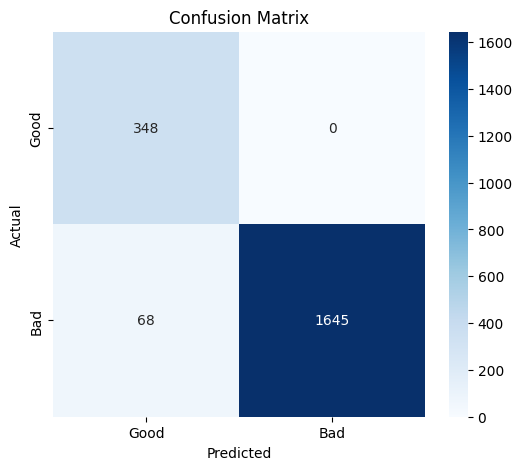

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# --- Reverse confusion matrix ---
conf_matrix_reversed = conf_matrix[::-1, ::-1]  # flip rows and columns
class_names_reversed = ["Good", "Bad"]  # reversed order

plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix_reversed, annot=True, fmt='d', cmap="Blues",
            xticklabels=class_names_reversed, yticklabels=class_names_reversed)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()
